In [ ]:
import kagglehub
himanshu007121_coughclassifier_trial_path = kagglehub.dataset_download('himanshu007121/coughclassifier-trial')

print('Data source import complete.')


100%|██████████| 94.9M/94.9M [00:02<00:00, 48.9MB/s]

Extracting files...


Data source import complete.


# Cough Analysis notebook

## Importing Libraries

In [ ]:
# feature extracting
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from datetime import datetime
from sklearn import metrics
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
plt.switch_backend('agg')
import itertools
import scipy as sp
from scipy import signal
import xgboost as xgb
import joblib
from glob import glob
import urllib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

## Spectrogram Extraction for every Audio File

In [ ]:
#Loading CSV file
train_csv = pd.read_csv("/root/.cache/Data/datasets/Sineha/coughclassifier-trial/Setup/25/cough_trial2.csv")
dataset = "/root/.cache/Data/datasets/Sineha/coughclassifier-trial/Setup/25/cough_trial2.csv"
train_csv

,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_respdisease
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_respdisease
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_respdisease
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_respdisease
4,cov1.wav,respdisease
...,...,...
165,-bZrDCS8KAg_ 70.000_ 80.000.wav,not_respdisease
166,-ej81N6Aqo4_ 0.000_ 8.000.wav,not_respdisease
167,-gvLnl1smfs_ 90.000_ 100.000.wav,not_respdisease
168,-hu5q-Nn4BM_ 70.000_ 80.000.wav,not_respdisease


In [ ]:
train_csv['class'].unique()

array(['not_respdisease', 'respdisease'], dtype=object)

In [ ]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
for i in range(tot_rows):
    source = train_csv['file_properties'][i]
    filename = '/root/.cache/Data/datasets/Sineha/coughclassifier-trial/Setup/25/COUGHVID/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

All the audio files get converted into their respective spectrograms .We can know easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Analysing the Data in Pandas

In [ ]:
data = pd.read_csv('/root/.cache/Data/datasets/Sineha/coughclassifier-trial/Setup/25/data_new_1.csv')
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0v8MGxNetjg_,0.519951,0.045853,1612.895795,1411.838677,2907.580566,0.107019,-376.876007,111.017372,-31.904015,...,-7.439712,-1.034580,-0.203084,-3.513495,-1.745704,-3.011878,-2.878482,-2.106427,-4.026825,not_covid
1,1j1duoxdxBg_,0.535472,0.001771,2892.087076,2467.408141,5072.664388,0.148584,-519.158447,60.781284,-13.722884,...,-0.909972,7.216461,-1.719630,3.903021,3.653039,3.043882,2.439958,2.781968,2.195162,not_covid
2,1MSYO4wgiag_,0.496666,0.033657,3429.061935,2788.634413,6886.288452,0.225315,-282.297913,48.581680,-15.522367,...,-6.066336,-4.167640,1.017302,-0.523806,0.538693,-8.855953,-2.927977,-1.118562,-5.906227,not_covid
3,1PajbAKd8Kg_,0.407549,0.013452,2710.811637,2664.287550,5778.474935,0.142076,-346.857300,75.765617,-7.648193,...,5.053118,-0.291308,0.987186,-2.447526,3.692367,2.312328,-2.059656,-4.772599,-0.503851,not_covid
4,cov1,0.412697,0.059004,1555.648634,1418.599932,2870.737092,0.133998,-340.588013,104.156700,-32.228443,...,-8.247169,0.940006,-5.701087,-6.326630,-1.080040,-1.812609,-2.518986,-3.684266,-3.564146,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,#NAME?,0.492974,0.005093,1600.647469,2300.999728,3660.644531,0.047815,-543.776916,119.100296,23.902969,...,-1.250754,-2.634280,1.647435,0.647164,1.602689,-2.469729,0.704325,-5.352920,-1.281080,not_covid
166,#NAME?,0.400283,0.052132,2664.129566,2563.440387,5518.182373,0.121514,-290.840607,85.514412,-10.986873,...,-4.629812,-7.424622,-4.511141,-7.482200,-4.865530,-6.353733,-5.024187,-8.422812,-0.831208,not_covid
167,#NAME?,0.704281,0.058739,3090.031219,2740.856272,6530.841064,0.179077,-75.595451,68.849228,-11.665833,...,0.677697,-7.535110,0.602187,-6.629556,0.659050,-4.125256,0.734950,-4.655417,-0.645009,not_covid
168,#NAME?,0.424896,0.044159,3173.872023,2482.951387,5768.306478,0.221743,-264.064514,58.729767,-7.446329,...,-0.625627,0.677355,-3.651989,-6.051375,1.211774,-14.923816,-11.180058,-8.861262,-5.078876,not_covid


In [ ]:
data.shape

(170, 28)

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Labels Encoding

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Train Test split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
X_train.shape

(113, 26)

In [ ]:
X_train.shape[1]

26

In [ ]:
y_train.shape

(113,)

# Classification



Saved model to disk


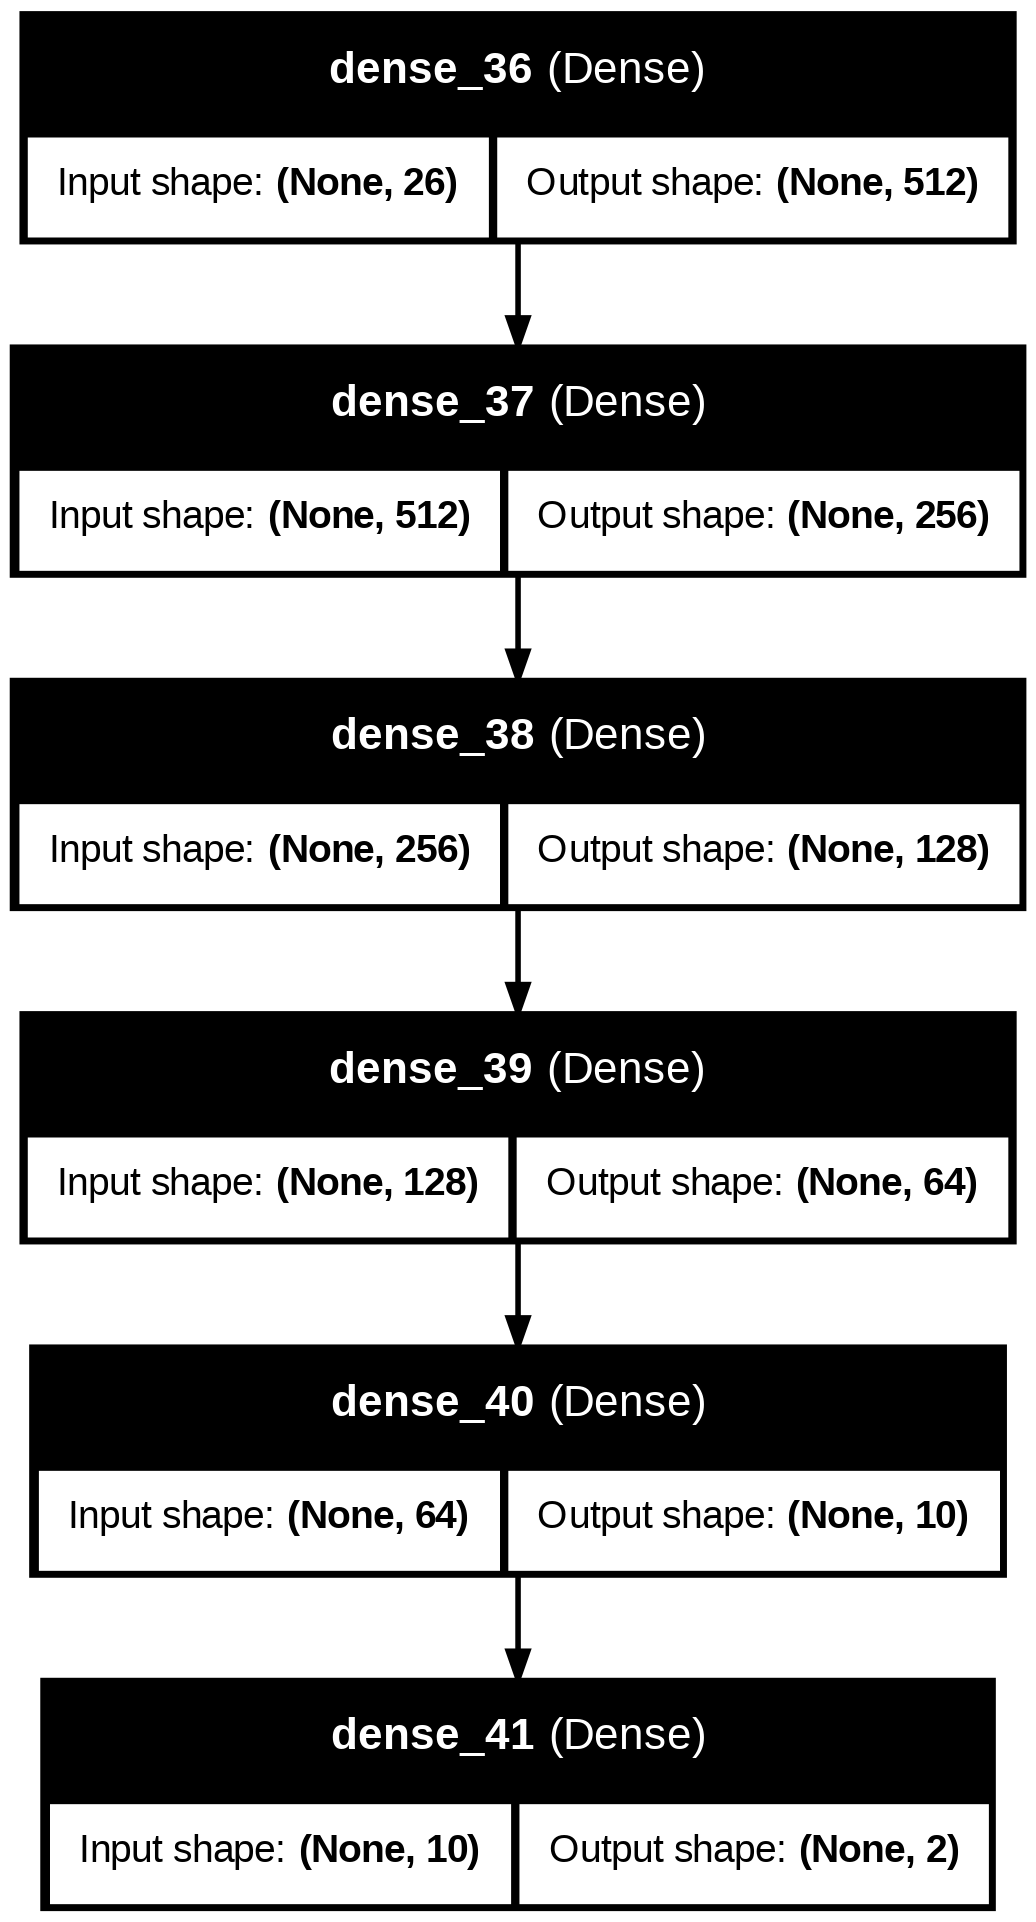

In [ ]:

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
 # serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

# plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 512)                 │          13,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,976 (730.38 KB)

 Trainable params: 186,976 (730.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # loading weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3009 - loss: 0.7025
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9027 - loss: 0.5968
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9027 - loss: 0.4598
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9027 - loss: 0.3503
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9027 - loss: 0.2806
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9027 - loss: 0.2450
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9027 - loss: 0.2267
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9027 - loss: 0.2095
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9027 - loss: 0.1878
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9027 - loss: 0.1632
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9027 - loss: 0.1395
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9027 - los

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9558 - loss: 0.2317 


### Accuracy

In [ ]:
print('test_acc: ',test_acc)

test_acc:  0.9649122953414917


## Predictions on Test Data

In [ ]:
predictions = model.predict(X_test)
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(predictions[:4])
print(y_test[:4])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(2,)
0.99999994
[[2.4846908e-12 9.9999994e-01]
 [9.9715906e-01 2.8408435e-03]
 [9.9997824e-01 2.1643891e-05]
 [2.9072161e-11 9.9999994e-01]]
[1 1 0 1]


In [ ]:
df = pd.DataFrame(predictions, columns = ['Negative','Positive'])

In [ ]:
a = df.iloc[:,0] < df.iloc[:,1]
a = a*1

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [ ]:
a.to_numpy()

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Model: auROC=0.927


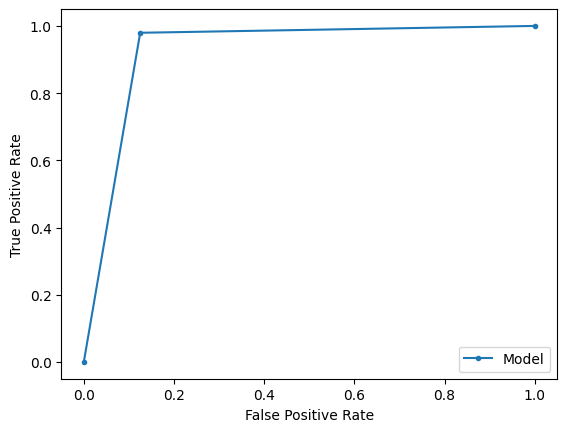

In [ ]:
# summarize score
print('Model: auROC=%.3f' % (roc_auc_score(y_test, a)))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, a)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()